# Toolbox Inventory

## Feature Engineering

- One-hot encoding
- Content Knowledge Is Included

## Validation / Error Estimation

- Training v Testing
- Cross Validation
- Bootstrapping

## Pre-processing Tools

- Singular Value Decomospition, Principal Component Analysis

## Tools for Regression

- Linear Regression
- K-Nearest Neighbors for Regression

## Tools for Classification

- Logistic Regression
- K-Nearest Neighbors for Classification

# Ridge and Lasso Regression

Today we are going to explore two more Linear Regression methods. Next class we will explore additional classification methods: *Linear Discriminant Analysis*, *Support Vector Machines*

It is worth pausing though and pointing out that we will not have time in this class to go over every method. It is worth reading through the documentation on the scikitlearn help page to see the complete lists of methods for which we have algorithms. The documentation includes a discussion of the mathematical underpinnings of the methods as well as some advice on what problems or types of issues they are meant to work best on.

[scikitlearn documentation](https://scikit-learn.org/stable/)

To review: 

**Advantages of Linear Regression**: 
- Fast model to train, 
- founded on mathematical principles from basic courses (*Linear Algebra and Calculus*), 
- easy model to interpret (the coeffecients tell us the precise effect of the features)
- Rigid model (less chance of overfitting)
- Adding additional features improves the $R^2$ for the training data

**Disadvantages of Linear Regression**:
- Assumes linear relationships (can be mitigated in some cases by transforming features to new features)
- Requires lots of features if they are categorical
- Rigid model (will not respond to nonlinearity)
- Adding additional features may not improve the $R^2$ for the testing data

**A new disadvantage**:
- Interpretation becomes hard if the number of features used is very large. 
- Adding additional features makes the model found more complicated

Meaning the algorithm finds the best linear model for the result from the predictors which will mean that it has a tendency to use all of the features and assign a non-zero coefficient to them. This is problematic because:

1. It makes interpretation difficult because the model developed incorporates every feature;
2. It also makes the model dependent on less important features and might therefore introduce overfitting depending on the training data.

Overall the principal is that given two linear models for our data with comparable errors on the testing data, we would prefer the one that has more coefficients that are zero or near zero. There is nothing in our Linear Regression method that encourages coefficients to not get too large.

We will develop two new models below, based on the principle of linear regression, but with an adjustment that will result in encouraging them to find models with small or zero coefficients. We will see that both models outperform *Linear Regression* at least in the test case and provided we choose the parameters carefully.

And that last sentence is the real description of what we are doing, we are introducing a parameter to the model that will give us some tuning or adjustment we can make to encourage the model to perform better, similar to the $k$ in $k$-*Nearest Neighbors*. Note that *Linear Regression* had no such thing.

## House Pricing Data

The difference between *Linear Regression* and *Ridge or LASSO Regression* becomes apparent when the number of features is large. Hence we will work with the House Pricing Data we have seen before, and we need to do some preliminary work to convert a number of categorical features into numerical ones. I stopped before I was completely done but you can get the idea.

In [1]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Consider the following dataset about homes that sold in a city in Iowa

hd = pa.read_csv('Data Sets/house-prices/train.csv')

hd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
def onehot(df, feature):
    '''A function to do one-hot-encoding of a feature from a dataframe. df = dataframe'''

    v = list(set(df[feature])) # Make an iterable of the unique values for the feature
    
    for c in df.index: # cycle through the samples
        t = df.loc[c, feature]
        
        for test in v:
            if pa.isna(test):  # nan values are sort of a problem and have to be handled separately
                if pa.isna(t):
                    df.loc[c, '{}_nan'.format(feature)] = 1
                else:
                    df.loc[c, '{}_nan'.format(feature)] = 0
            else:
                if t == test:
                    df.loc[c, '{}_{}'.format(feature, test)] = 1  # Makes a new feature with name feature_value
                                                              # and codes it as a 1 if that was the value
                else:
                    df.loc[c, '{}_{}'.format(feature, test)] = 0  # and 0 otherwise
            
    return df.drop(feature, axis=1) # returns a dataframe with the encoded feature removed

In [4]:
# We can recode it using a dictionary and .map()
Street_dict = {'Grvl':0, 'Pave':1, 0:0, 1:1}  
# Note we include the trivial coding of the new values as otherwise if we run this twice
# it produces NaN values for the Street feature.
hd.Street = hd.Street.map(Street_dict)
set(hd.Street)

{0, 1}

In [5]:
hd2 = onehot(hd, 'Alley')
hd3 = onehot(onehot(onehot(hd2, 'ExterQual'), 'LotShape'), 'LandContour')
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_TA,ExterQual_Gd,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_IR1,LandContour_Bnk,LandContour_Lvl,LandContour_HLS,LandContour_Low
0,1,60,RL,65.0,8450,1,AllPub,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2,20,RL,80.0,9600,1,AllPub,FR2,Gtl,Veenker,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,60,RL,68.0,11250,1,AllPub,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,70,RL,60.0,9550,1,AllPub,Corner,Gtl,Crawfor,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5,60,RL,84.0,14260,1,AllPub,FR2,Gtl,NoRidge,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
Utilities_dict = {'AllPub':1, 'NoSeWa':0, 1:1, 0:0}
hd3.Utilities = hd3.Utilities.map(Utilities_dict)
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_TA,ExterQual_Gd,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_IR1,LandContour_Bnk,LandContour_Lvl,LandContour_HLS,LandContour_Low
0,1,60,RL,65.0,8450,1,1,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2,20,RL,80.0,9600,1,1,FR2,Gtl,Veenker,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,60,RL,68.0,11250,1,1,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,70,RL,60.0,9550,1,1,Corner,Gtl,Crawfor,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5,60,RL,84.0,14260,1,1,FR2,Gtl,NoRidge,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
hd4 = onehot(onehot(onehot(onehot(hd3, 'LotConfig'), 'LandSlope'), 'Neighborhood'), 'MSZoning')
hd4.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,Condition1,Condition2,BldgType,HouseStyle,...,Neighborhood_NAmes,Neighborhood_BrDale,Neighborhood_SawyerW,Neighborhood_Blmngtn,Neighborhood_Sawyer,MSZoning_RM,MSZoning_RH,MSZoning_RL,MSZoning_C (all),MSZoning_FV
0,1,60,65.0,8450,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,20,80.0,9600,1,1,Feedr,Norm,1Fam,1Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,60,68.0,11250,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,70,60.0,9550,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,60,84.0,14260,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
def condition(df, feature1, feature2):
    
    #This is onehot encoding but for features that represent the same things 
    # - i.e. where a sample could have two values identified.
    
    v = set(list(set(df[feature1])) + list(set(df[feature2])))  # Build a list of the possible outputs
    
    for c in df.index: # cycle through the samples
        t1 = df.loc[c, feature1]
        t2 = df.loc[c, feature2]
        
        for test in v:
            if (t1==test) or (t2==test):
                df.loc[c, '{}_{}'.format(feature1, test)] = 1  # Makes a new feature with name feature_value
                                                            # and codes it as a 1 if that was the value
            else:
                df.loc[c, '{}_{}'.format(feature1, test)] = 0  # and 0 otherwise
            
    return df.drop([feature1, feature2], axis=1) # returns a dataframe with the encoded feature removed

In [9]:
hd5 = condition(hd4, 'Condition1', 'Condition2')
hd5.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,...,MSZoning_FV,Condition1_RRNn,Condition1_Artery,Condition1_Feedr,Condition1_PosA,Condition1_RRNe,Condition1_Norm,Condition1_PosN,Condition1_RRAn,Condition1_RRAe
0,1,60,65.0,8450,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,20,80.0,9600,1,1,1Fam,1Story,6,8,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,60,68.0,11250,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,70,60.0,9550,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,60,84.0,14260,1,1,1Fam,2Story,8,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
hd6 = onehot(onehot(onehot(onehot(hd5, 'BldgType'), 'HouseStyle'), 'RoofStyle'), 'RoofMatl')
hd6.iloc[:5, 9:]

,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,...,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_WdShngl,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_ClyTile,RoofMatl_Roll,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Membran
0,2003,VinylSd,VinylSd,BrkFace,196.0,TA,PConc,Gd,TA,No,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1976,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,TA,Gd,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2002,VinylSd,VinylSd,BrkFace,162.0,TA,PConc,Gd,TA,Mn,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1970,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,Gd,No,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2000,VinylSd,VinylSd,BrkFace,350.0,TA,PConc,Gd,TA,Av,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Probably enough, lets make a list of all of the features that are not 'object'
# (i.e. that are numerical)

keep = hd6.columns[hd6.dtypes!='object'][1:]
keep

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_WdShngl',
       'RoofMatl_WdShake', 'RoofMatl_CompShg', 'RoofMatl_ClyTile',
       'RoofMatl_Roll', 'RoofMatl_Metal', 'RoofMatl_Tar&Grv',
       'RoofMatl_Membran'],
      dtype='object', length=128)

So we have 128 features. That is a lot, and should be enough to illustrate the difference between *Linear Regression* and the new methods.

In [12]:
# Check for NaN

for v in keep:
    if sum(np.isnan(hd6[v]))!=0:
        print(v)

LotFrontage
MasVnrArea
GarageYrBlt


In [13]:
# MasVnrArea and GarageYrBlt that are NaN probably mean 0 (i.e. no Garage and no Masonry)

for k in hd6.index:
    if np.isnan(hd6.loc[k, 'MasVnrArea']):
        hd6.loc[k, 'MasVnrArea']=0
    if np.isnan(hd6.loc[k, 'GarageYrBlt']):
        hd6.loc[k, 'GarageYrBlt']=0


### Linear Regression

In [14]:
keep = list(hd6.columns[hd6.dtypes!='object'][1:])
keep.remove('LotFrontage')   # There are some NaNs in LotFrontage. We could try to fill them in with a regression.
                             # Or we might check with a content expert and see if they should be 0
hd7 = hd6.loc[:, keep]
hd7.head()

,MSSubClass,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_WdShngl,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_ClyTile,RoofMatl_Roll,RoofMatl_Metal,RoofMatl_Tar&Grv,RoofMatl_Membran
0,60,8450,1,1,7,5,2003,2003,196.0,706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,20,9600,1,1,6,8,1976,1976,0.0,978,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,60,11250,1,1,7,5,2001,2002,162.0,486,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,70,9550,1,1,7,5,1915,1970,0.0,216,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,14260,1,1,8,5,2000,2000,350.0,655,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Okay so there is our data frame. We start by seeing how *Linear Regression* does.

In [15]:
# Convert them to Numpy Arrays X for predictors and y for result

keep.remove('SalePrice')
X = np.array(hd7.loc[:, keep])
y = np.array(hd7.loc[:, 'SalePrice'])

In [16]:
import numpy.random as rn
from sklearn.linear_model import LinearRegression

In [19]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [20]:
reg = LinearRegression().fit(X_train, y_train)
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Training R2: 0.9025858129915478
Testing R2: 0.8664636832976602


Reasonably good on the training data, not so good on the testing data (again we really should do some cross validation or bootstrapping to fully explore it).  However, lets check a few things to see how the model is making its prediction, i.e. what our interpretation is.

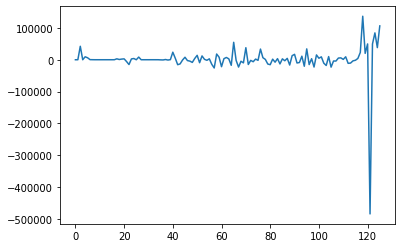

In [21]:
plt.plot(reg.coef_);

One feature stands out as particularly important.

In [22]:
# numpy.argmin() returns the index of the minimum value
keep[reg.coef_.argmin()] 
# It's position in keep is then the name of that feature

'RoofMatl_ClyTile'

In [23]:
keep[reg.coef_.argmax()]

'RoofMatl_WdShngl'

*side remark*: I would not have predicted that Wood Shingle was the most important positive feature.

We also can check the size of the smallest absolute coefficient and the largest absolute coefficient:


In [24]:
min(abs(reg.coef_)), max(abs(reg.coef_))

(7.380648476384977e-06, 484537.3182159475)

Wel some coefficients were zero, we can ask for how many they were actually zero:

In [25]:
sum( abs(reg.coef_)==0.0 )

0

Not many. And how many were small, say within 1 of zero (which compared to the largest coefficient is small):

In [26]:
sum( abs(reg.coef_)<1)

3

### Ridge Regression

Recall that *Linear Regression* seeks to minimize the sum of square residuals between the data $(x_i, y_i)$ and the linear prediction $\hat{y}_i = m_0 x_{i0} + m_1 x_{i1} + \dots m_{p-1} x_{i, p-1} + b$:

$$ E(m, b) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i)^2 $$

From this formulation, there is no penalty for the algorithm choosing coefficients $m_j$ that are big.
What we would like to do is introduce a penalty to $E(m, b)$ for choosing coefficients $m_j$ that are too big. Ridge Regression using the simple idea of introduce a penalty that is a sum of the squares of the $m_j$:

$$ E_{\alpha}(m, b) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=0}^{p-1} m_j^2 $$

First note that $\alpha > 0$ is a parameter that needs to be choosen. **Question**: How will we choose it? 

Then the effect of the $\alpha$ term is to increase $E$ if the choices for $m_j$ are large, i.e. it is a penalty for a Linear Model that uses larger coefficients. $\alpha$ effectively chooses how strong that penalty is.

*Note*: We choose the term $m_j^2$ so that it is differentiable with respect $m_j$ and thus the problem is still ammenable to our Calculus 1 approach to linear regression.

In [27]:
from sklearn.linear_model import Ridge

In [28]:
ridge_reg = Ridge(alpha=1).fit(X_train, y_train)
print('Training R2: {}'.format(ridge_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(ridge_reg.score(X_test, y_test)))

Training R2: 0.893675302595733
Testing R2: 0.8486405092126428


Reasonably good performance on the training data, somewhat less good on the testing data. The model does outperform *Linear Regression*. If you are following along with this discussion in Jupyter, you should try different values of $\alpha$ to see how the model responds. In production what we would really want to set up is a *Cross Validation* or *Bootstrap Procedure* to compare different choices of $\alpha$ across a range of testing and training sets.

In [48]:
ridge_reg = Ridge(alpha=100).fit(X_train, y_train)
print('Training R2: {}'.format(ridge_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(ridge_reg.score(X_test, y_test)))

Training R2: 0.8438627938969168
Testing R2: 0.8106921982362254


Check the size of the coefficients.

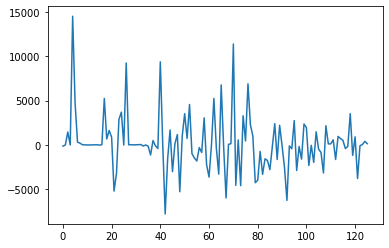

In [49]:
plt.plot(ridge_reg.coef_);

In [50]:
# numpy.argmin() returns the index of the maximum value
keep[ridge_reg.coef_.argmax()] 
# It's position in keep is then the name of that feature

'OverallQual'

Interestingly this model (if you have choosen a large $\alpha$) gives a different feature as the most important.

The largest absolute coefficient from the Ridge model is much smaller than that from the Linear Regression model.

In [51]:
min(abs(ridge_reg.coef_)), max(abs(ridge_reg.coef_))

(0.0, 14524.17103845617)

In [52]:
sum(reg.coef_**2) - sum(ridge_reg.coef_**2)

296412694544.19495

However not many coefficients are exactly 0 (again the result will vary as your testing and training sets change). And indeed about the same number of coefficients are small for this model.

In [53]:
sum(abs(ridge_reg.coef_)==0.0)

1

In [54]:
sum(abs(ridge_reg.coef_)<1)

3

### Lasso Regression

So *Ridge Regression* did some of what we wanted. It produced a Linear Model that had overall smaller coefficients, and in the process that model while it did worse on the training data (which it had to, remember that *Linear Regression* chooses the model that will do the best out of any linear function at predicting the training data) it performed better on the testing data (though keeping in mind we really should test that statement more carefully). The model was also tuneable, we could choose an $\alpha$ that produced a blance between training and testing $R^2$ values (though again we are skipping the bootstrapping step).

However it still (in most cases I've run) produced a model with quite a few coefficients that were non-zero. We would prefer models where as many coefficients are zero while still performing well because we expect it will produce a model that is easier to interpret.

The idea with *Lasso Regression* is to introduce a new objective function that will include a different penalty that responds faster to small values of the coefficients, thus encouraging them to go to zero. 
We will choose a model that is not differentiable in the $m_j$ coefficients, and thus it will need to use a different solution method than our Calculus 1 approach to *Linear and Ridge Regression*. Define the new objective function:

$$ E_{\alpha}(m, b) = \frac{1}{2n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=0}^{p-1} | m_j | $$

Note that because we are dividing the first term by the number of samples this also puts more pressure on the penalty term. This objective function cannot be minimized by solving it exactly using Calculus 1 techniques. Instead what the algorithm does is search for a solution by choosing values of $m_j$ and $b$ that improve on the current value, a form of gradient descent. This is therefore our first example of a model that does not give an exact result from a given training set.

In [55]:
from sklearn.linear_model import Lasso

In [58]:
lasso_reg = Lasso(alpha=5).fit(X_train, y_train)
print('Training R2: {}'.format(lasso_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(lasso_reg.score(X_test, y_test)))

Training R2: 0.9025003562935427
Testing R2: 0.8664778334350348


Because the algorithm is using an approximation method to arrive at the model, if your $\alpha$ is too small you will get a warning that the solution did not converge in the maximum number of iterations. You should either increase $\alpha$ until you do not see this error, or increase the maximum number of iterations by adding that parameter to the call of the model.

Note the model performed well on the training data, but underperformed *Ridge Regression* on the testing data (for this choice of $\alpha$). However you know what needs to be done, we need to search for a better choice of $\alpha$. 

In [77]:
lasso_reg = Lasso(alpha=60*10^9).fit(X_train, y_train)
print('Training R2: {}'.format(lasso_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(lasso_reg.score(X_test, y_test)))

Training R2: 0.8377552799110077
Testing R2: 0.8090466295901743


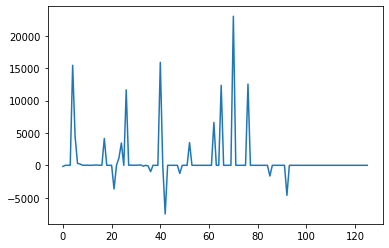

In [78]:
plt.plot(lasso_reg.coef_);

In [74]:
min(abs(lasso_reg.coef_)), max(abs(lasso_reg.coef_))

(0.0, 23036.317397777835)

The coefficients are small, and many of them are 0 compared with the *Linear and Ridge Regression* models. Note that the performance of the model on the test set is comparable with those models. 

In [75]:
sum(abs(lasso_reg.coef_)==0.0)

85

In [76]:
sum(abs(lasso_reg.coef_)<1)

87